# Post-Processing Sampling Results

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/Bump10MSun`


In [2]:
using ArviZ
using Bump10MSun
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using LaTeXStrings
using Printf
using StatsBase
using StatsPlots
using Trapz
using Turing

## Preliminaries

In [3]:
default(palette=categorical_palette(4))

## Load Traces, Check Convergence

In [4]:
traces = Dict(k => from_netcdf(joinpath(@__DIR__, "..", "chains", "chain" * suffix_map[k] * ".nc")) for k in keys(suffix_map))
extra_traces = Dict(k => from_netcdf(joinpath(@__DIR__, "..", "chains", "chain" * suffix_map[k] * "_extra.nc")) for k in keys(suffix_map))

Dict{Tuple{MassFunction, PowerLawPairing}, InferenceData{(:posterior, :sample_stats)}} with 2 entries:
  (BrokenPowerLaw(), Power… => InferenceData{(:posterior, :sample_stats), Tuple…
  (PowerLawGaussian(), Pow… => InferenceData{(:posterior, :sample_stats), Tuple…

In [5]:
S_name = DimensionalData.index(extra_traces[(PowerLawGaussian(), PowerLawPairing())].posterior, :gwnames)[end]

"S230529ay"

Let's check for convergence:

In [6]:
for (k, t) in pairs(traces)
    println(k)
    @printf("  Min Neff_sel = %.1f (4*Nobs = %d)\n", minimum(t.posterior[:Neff_sel]), 4*length(t.posterior.m1s_popwt[draw=At(1), chain=At(1)]))
    @printf("  Min Neff_samps = %.1f\n", minimum(t.posterior[:Neff_samps]))
end

(BrokenPowerLaw(), PowerLawPairing())
  Min Neff_sel = 775.8 (4*Nobs = 100)
  Min Neff_samps = 2.4
(PowerLawGaussian(), PowerLawPairing())
  Min Neff_sel = 375.0 (4*Nobs = 100)
  Min Neff_samps = 3.4


In [7]:
for (k, t) in pairs(extra_traces)
    println(k)
    @printf("  Min Neff_sel = %.1f (4*Nobs = %d)\n", minimum(t.posterior[:Neff_sel]), 4*length(t.posterior.m1s_popwt[draw=At(1), chain=At(1)]))
    @printf("  Min Neff_samps = %.1f\n", minimum(t.posterior[:Neff_samps]))
end

(BrokenPowerLaw(), PowerLawPairing())
  Min Neff_sel = 806.9 (4*Nobs = 104)
  Min Neff_samps = 20.0
(PowerLawGaussian(), PowerLawPairing())
  Min Neff_sel = 564.8 (4*Nobs = 104)
  Min Neff_samps = 3.1


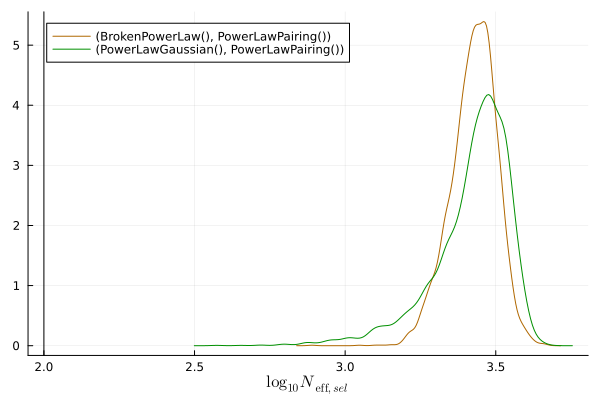

In [8]:
p = plot(xlabel=L"\log_{10} N_{\mathrm{eff}, sel}")
for (k, t) in pairs(traces)
    p = density!(log10.(vec(t.posterior.Neff_sel)), label=string(k))
end
p = vline!([log10(4 * size(traces[PowerLawGaussian(), PowerLawPairing()].posterior.m1s_popwt, 3))], color=:black, label=nothing)
p

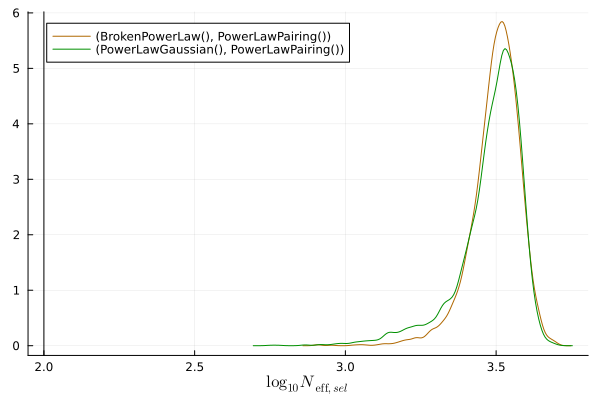

In [9]:
p = plot(xlabel=L"\log_{10} N_{\mathrm{eff}, sel}")
for (k, t) in pairs(extra_traces)
    p = density!(log10.(vec(t.posterior.Neff_sel)), label=string(k))
end
p = vline!([log10(4 * size(traces[PowerLawGaussian(), PowerLawPairing()].posterior.m1s_popwt, 3))], color=:black, label=nothing)
p

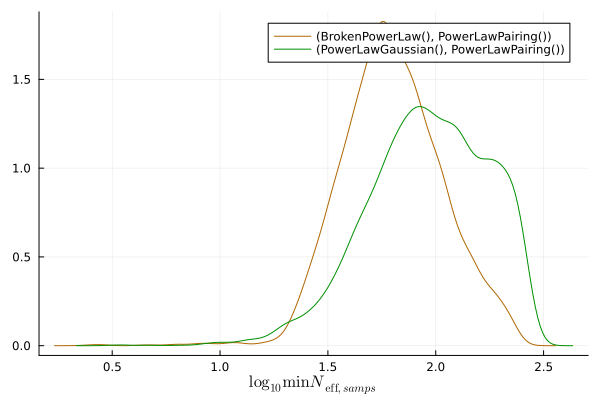

In [10]:
p = plot(xlabel=L"\log_{10} \min N_{\mathrm{eff}, samps}")
for (k, t) in pairs(traces)
    p = density!(log10.(vec(minimum(t.posterior.Neff_samps, dims=:gwnames))), label=string(k))
end
p

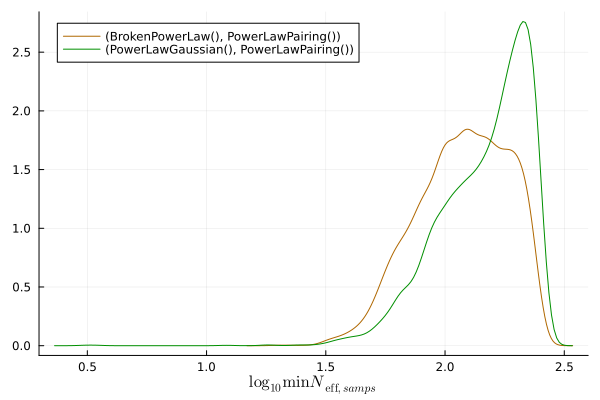

In [11]:
p = plot(xlabel=L"\log_{10} \min N_{\mathrm{eff}, samps}")
for (k, t) in pairs(extra_traces)
    p = density!(log10.(vec(minimum(t.posterior.Neff_samps, dims=:gwnames))), label=string(k))
end
p

And we can take a quick look at the traceplots:

(BrokenPowerLaw(), PowerLawPairing())
(PowerLawGaussian(), PowerLawPairing())


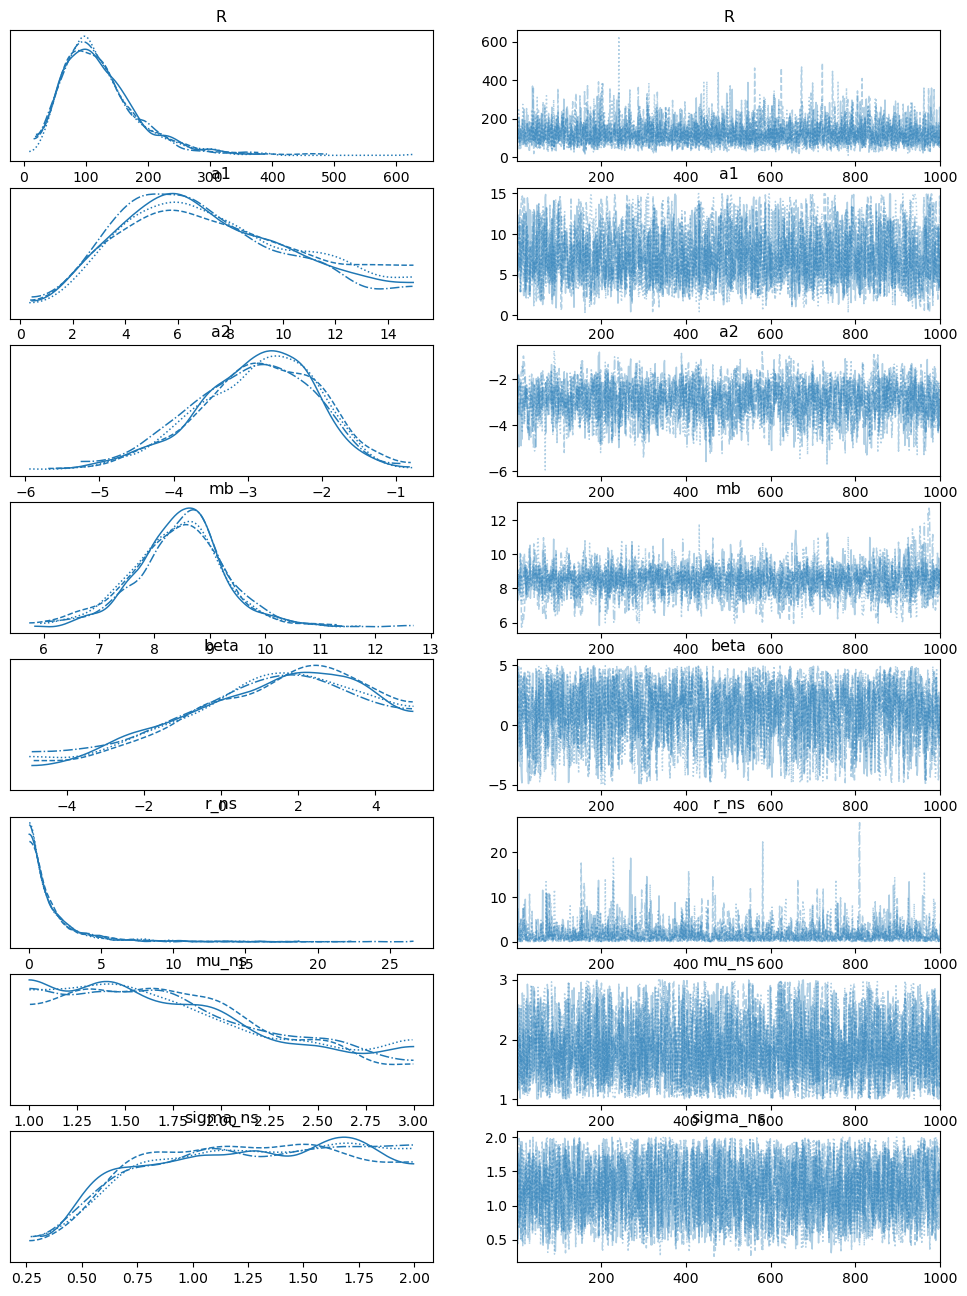

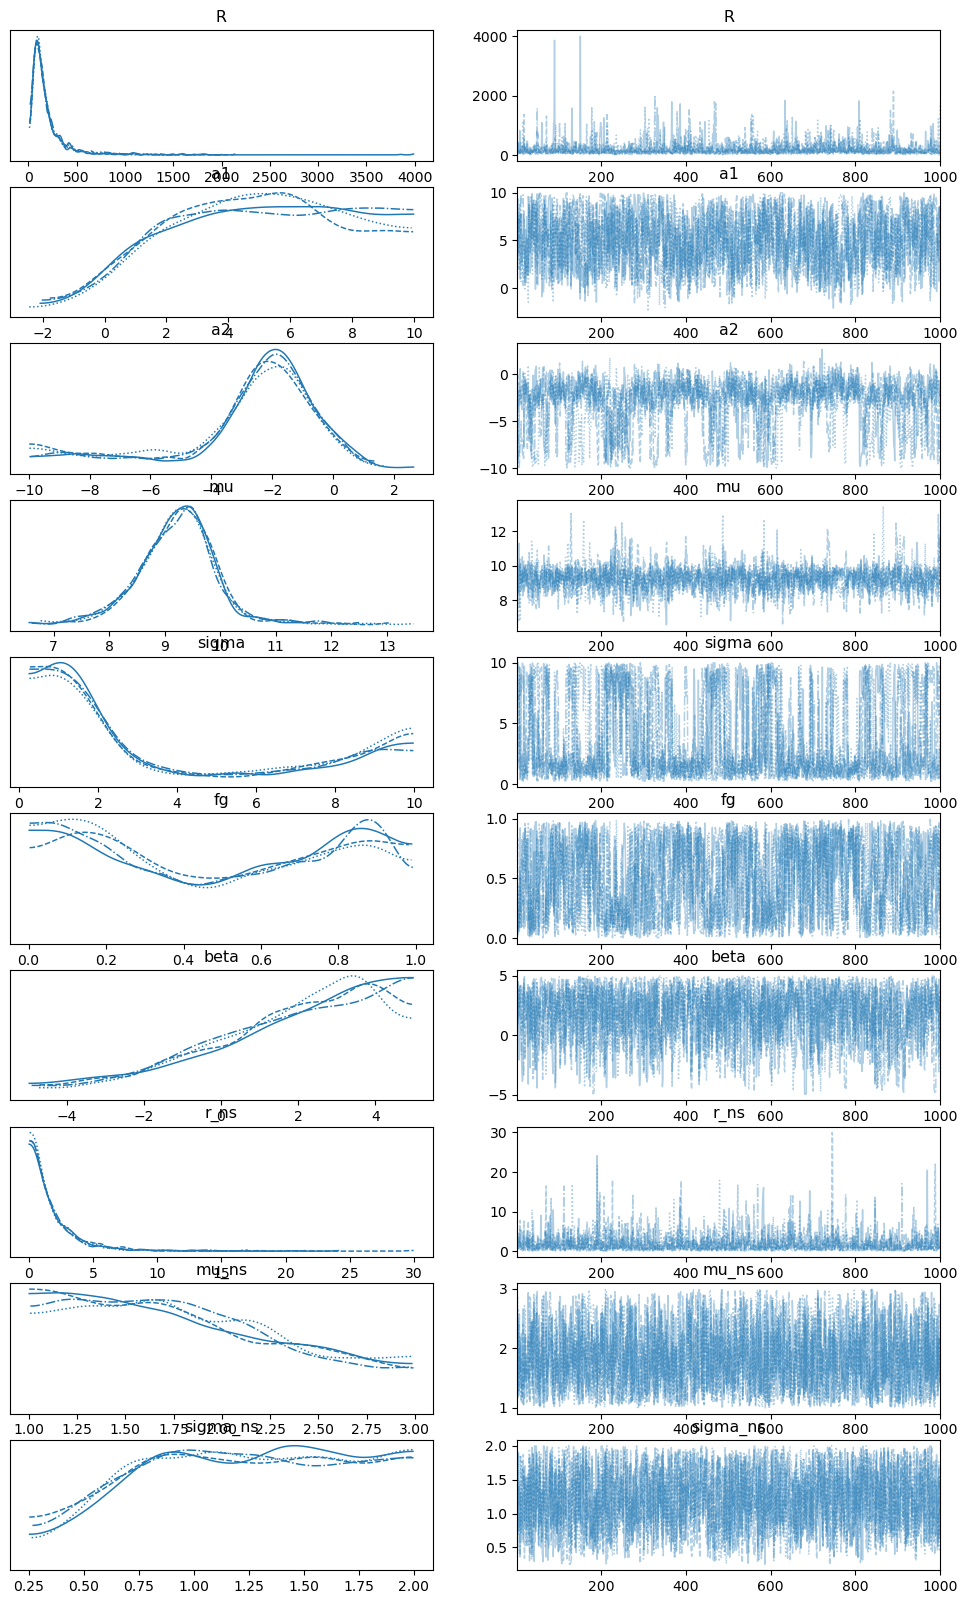

In [12]:
for (k, t) in pairs(traces)
    println(k)
    plot_trace(t, var_names=var_name_map[k[1:2]])
end

(BrokenPowerLaw(), PowerLawPairing())
(PowerLawGaussian(), PowerLawPairing())


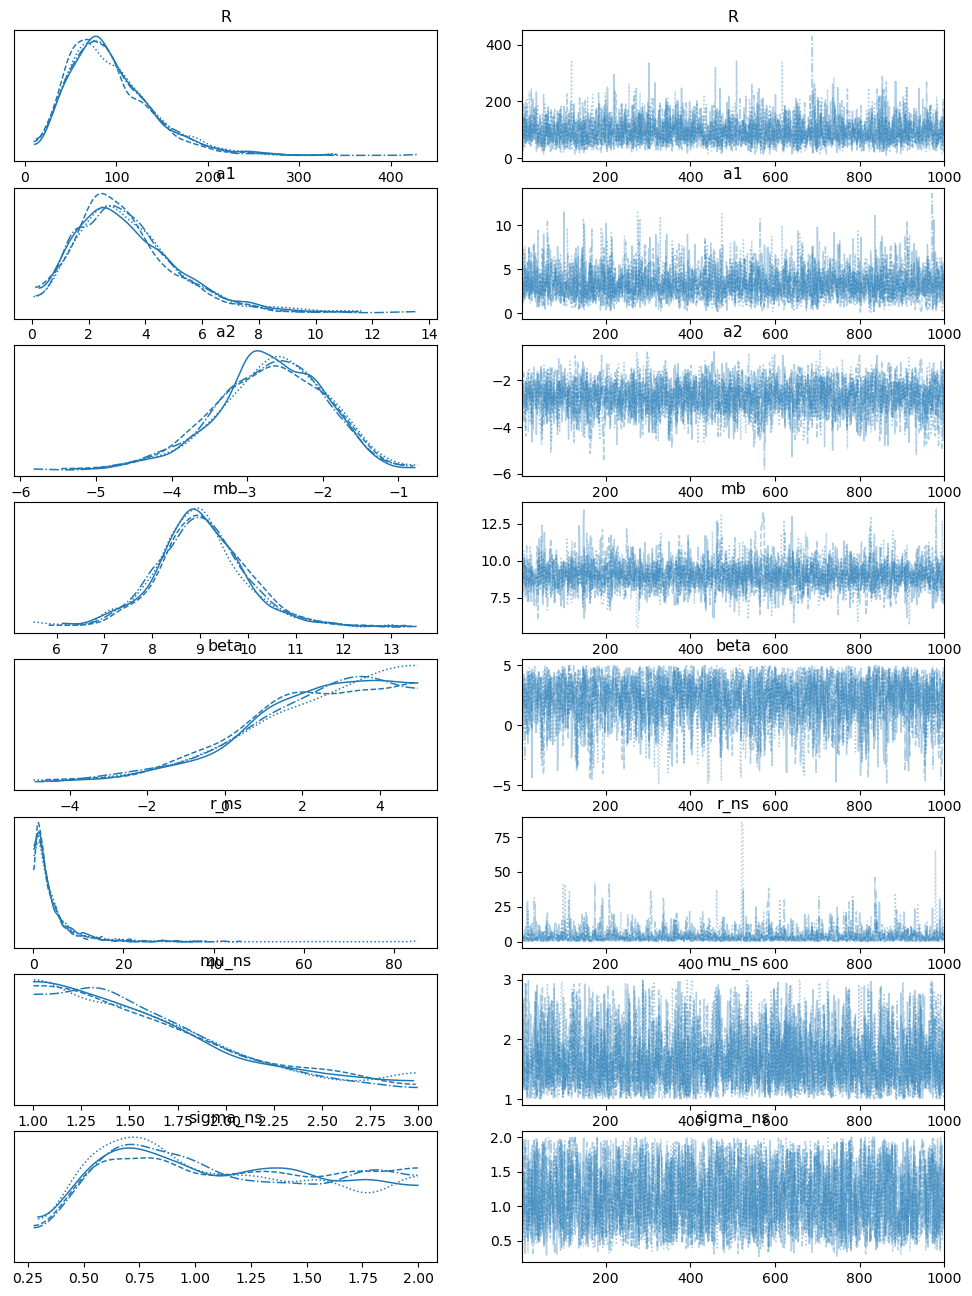

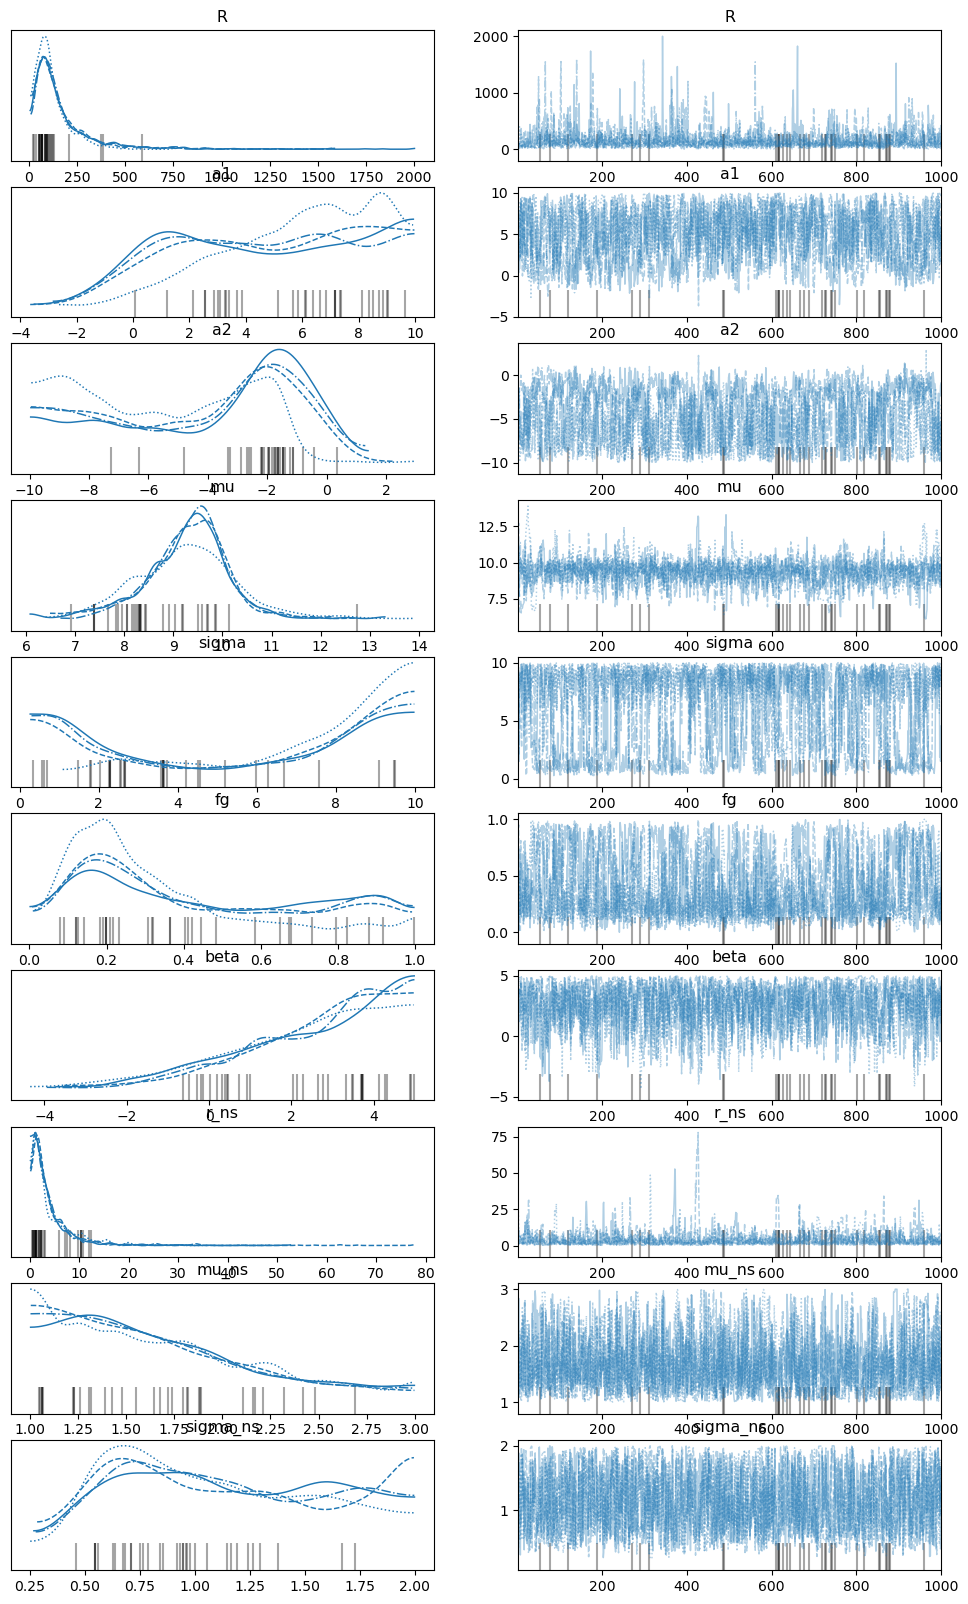

In [13]:
for (k, t) in pairs(extra_traces)
    println(k)
    plot_trace(t, var_names=var_name_map[k[1:2]])
end

In [14]:
for (k, t) in pairs(traces)
    println(k)
    display(summarystats(t, var_names=var_name_map[k[1:2]]))
end

(BrokenPowerLaw(), PowerLawPairing())


8×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         124.092   62.846   24.524  234.82       0.998    0.733    395 ⋯
   2 │ a1          7.355    3.357    1.937   13.85       0.072    0.055    228
   3 │ a2         -2.887    0.804   -4.502   -1.528      0.021    0.015    140
   4 │ mb          8.449    0.84     6.814   10.1        0.022    0.015    160
   5 │ beta        1.019    2.422   -3.299    4.979      0.061    0.043    157 ⋯
   6 │ r_ns        1.662    2.161    0.011    5.142      0.045    0.032    180
   7 │ mu_ns       1.825    0.539    1.002    2.781      0.01     0.007    276
   8 │ sigma_ns    1.253    0.439    0.568    1.999      0.008    0.006    266
                                                               3 columns omitted

(PowerLawGaussian(), PowerLawPairing())


10×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         190.422  217.835    9.295  485.413      4.677    3.308    186 ⋯
   2 │ a1          5.043    2.824    0.573    9.991      0.094    0.066     93
   3 │ a2         -2.861    2.461   -8.9      0.523      0.14     0.099     34
   4 │ mu          9.234    0.71     7.706   10.388      0.017    0.012    184
   5 │ sigma       3.469    3.287    0.25     9.535      0.199    0.141     36 ⋯
   6 │ fg          0.486    0.308    0.011    0.93       0.015    0.011     53
   7 │ beta        1.852    2.245   -2.269    4.998      0.053    0.037    171
   8 │ r_ns        1.859    2.294    0.028    5.394      0.05     0.036    181
   9 │ mu_ns       1.829    0.537    1.005    2.776      0.011    0.008    251 ⋯
  10 │ sigma_ns    1.221    0.458    0.502    2.0        0.009    0.007    239
                                                               3 columns omitted

In [15]:
for (k, t) in pairs(extra_traces)
    println(k)
    display(summarystats(t, var_names=var_name_map[k[1:2]]))
end

(BrokenPowerLaw(), PowerLawPairing())


8×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R          93.169   45.539   20.99   177.934      0.747    0.534    356 ⋯
   2 │ a1          3.324    1.762    0.403    6.523      0.03     0.022    329
   3 │ a2         -2.686    0.718   -4.032   -1.381      0.015    0.011    233
   4 │ mb          9.025    0.971    7.089   10.8        0.022    0.016    221
   5 │ beta        2.219    1.965   -1.303    4.992      0.044    0.031    186 ⋯
   6 │ r_ns        4.237    5.598    0.039   12.442      0.139    0.114    204
   7 │ mu_ns       1.657    0.494    1.001    2.608      0.009    0.007    304
   8 │ sigma_ns    1.142    0.469    0.447    1.965      0.01     0.007    216
                                                               3 columns omitted

(PowerLawGaussian(), PowerLawPairing())


10×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         154.566  161.764    7.315  397.513      6.009    4.251     70 ⋯
   2 │ a1          5.005    3.156   -0.055    9.955      0.171    0.121     37
   3 │ a2         -4.397    3.092   -9.86    -0.254      0.195    0.138     24
   4 │ mu          9.286    0.899    7.378   10.866      0.036    0.026     66
   5 │ sigma       6.127    3.427    0.663    9.971      0.33     0.239     12 ⋯
   6 │ fg          0.391    0.276    0.061    0.938      0.018    0.013     39
   7 │ beta        2.58     1.837   -0.705    4.998      0.059    0.044     91
   8 │ r_ns        4.005    5.133    0.081   11.411      0.196    0.14      84
   9 │ mu_ns       1.672    0.496    1.001    2.63       0.016    0.011     84 ⋯
  10 │ sigma_ns    1.127    0.468    0.465    1.981      0.013    0.009    141
                                                               3 columns omitted

## Mass Functions

In [16]:
dNdm1dm2_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    ldN = make_log_dN(k[1], k[2], args[2:end]...)
    (m1, m2) -> args[1]*exp(ldN(m1, m2))         
end for k in keys(traces))
dNdm1_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdm1(k[1], k[2], args[2:end]...)
    m1 -> args[1]*dN(m1)
end for k in keys(traces))
dNdm2_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdm2(k[1], k[2], args[2:end]...)
    m2 -> args[1]*dN(m2)
end for k in keys(traces))
dNdq_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdq(k[1], k[2], args[2:end]...)
    q -> args[1]*dN(q)
end for k in keys(traces))
pm_map = Dict(k => map([traces[k].posterior[v] for v in vcat(mf_var_name_map[k[1]], ns_var_names)]...) do args...
    make_dNdm(k[1], args[2:end]...)
end for k in keys(traces))

Dict{Tuple{MassFunction, PowerLawPairing}, DimArray{T, 2, Tuple{Dim{:draw, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}, Dim{:chain, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}}, Tuple{}, A, Symbol, DimensionalData.Dimensions.LookupArrays.NoMetadata} where {T, A<:AbstractMatrix{T}}} with 2 entries:
  (BrokenPowerLaw(), Power… => var"#18#19"{BrokenPowerLaw, NTuple{6, Float64}}[…
  (PowerLawGaussian(), Pow… => var"#18#19"{PowerLawGaussian, NTuple{8, Float64}…

In [17]:
dNdm1dm2_extra_map = Dict(k => map([extra_traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    ldN = make_log_dN(k[1], k[2], args[2:end]...)
    (m1, m2) -> args[1]*exp(ldN(m1, m2))         
end for k in keys(traces))
dNdm1_extra_map = Dict(k => map([extra_traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdm1(k[1], k[2], args[2:end]...)
    m1 -> args[1]*dN(m1)
end for k in keys(traces))
dNdm2_extra_map = Dict(k => map([extra_traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdm2(k[1], k[2], args[2:end]...)
    m2 -> args[1]*dN(m2)
end for k in keys(traces))
dNdq_extra_map = Dict(k => map([extra_traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdq(k[1], k[2], args[2:end]...)
    q -> args[1]*dN(q)
end for k in keys(traces))
pm_extra_map = Dict(k => map([extra_traces[k].posterior[v] for v in vcat(mf_var_name_map[k[1]], ns_var_names)]...) do args...
    make_dNdm(k[1], args[2:end]...)
end for k in keys(traces))

Dict{Tuple{MassFunction, PowerLawPairing}, DimArray{T, 2, Tuple{Dim{:draw, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}, Dim{:chain, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}}, Tuple{}, A, Symbol, DimensionalData.Dimensions.LookupArrays.NoMetadata} where {T, A<:AbstractMatrix{T}}} with 2 entries:
  (BrokenPowerLaw(), Power… => var"#18#19"{BrokenPowerLaw, NTuple{6, Float64}}[…
  (PowerLawGaussian(), Pow… => var"#18#19"{PowerLawGaussian, NTuple{8, Float64}…

In [18]:
ms = exp.(log(m_lower_limit):0.01:log(m_upper_limit))
ms = ms[2:end-1]
qs = collect(range(m_lower_limit/m_upper_limit, 1, length=129))[2:end]

function make_mean_map(xs, dN_map)
    Dict(
        k => begin
            dN_mean = zeros(length(xs))
            for dN in v
                dN_mean .= dN_mean .+ dN.(xs)
            end
            dN_mean .= dN_mean ./ length(v)
            dN_mean
        end
        for (k,v) in pairs(dN_map)
    )
end

dN1_mean_map = make_mean_map(ms, dNdm1_map)
dN2_mean_map = make_mean_map(ms, dNdm2_map)
dNq_mean_map = make_mean_map(qs, dNdq_map)

dN1_mean_extra_map = make_mean_map(ms, dNdm1_extra_map)
dN2_mean_extra_map = make_mean_map(ms, dNdm2_extra_map)
dNq_mean_extra_map = make_mean_map(qs, dNdq_extra_map)

Dict{Tuple{MassFunction, PowerLawPairing}, Vector{Float64}} with 2 entries:
  (BrokenPowerLaw(), Power… => [13.7709, 27.5974, 41.4589, 55.6331, 70.6042, 86…
  (PowerLawGaussian(), Pow… => [11.1995, 23.1946, 36.8847, 51.2626, 65.4842, 79…

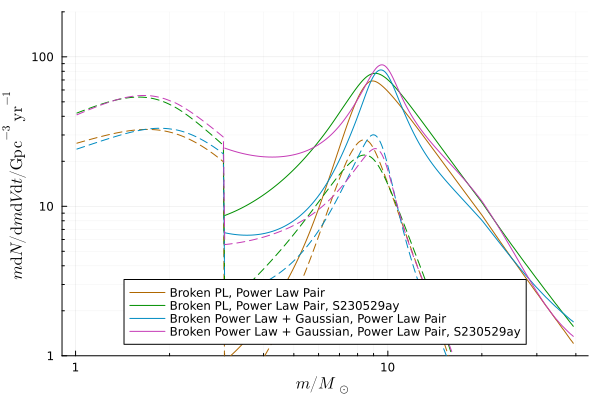

In [19]:
i = 1
p = plot(xlabel=L"m / M_\odot", ylabel=L"m \mathrm{d} N / \mathrm{d} m \mathrm{d} V \mathrm{d} t / \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}", formatter=s->@sprintf("%.0f", s), minorgrid=true, yscale=:log10, ylims=(1, 200), xscale=:log10)
for mf in [BrokenPowerLaw(), PowerLawGaussian()]
    pf = PowerLawPairing()
    k = (mf, pf)
    v = dN1_mean_map[k]
    p = plot!(ms, ms .* v, label=label_map[k], color=2*i-1)
    p = plot!(ms, ms .* dN2_mean_map[k], label=nothing, color=2*i-1, linestyle=:dash)

    v = dN1_mean_extra_map[k]
    p = plot!(ms, ms .* v, label=label_map[k] * ", " * S_name, color=2*i)
    p = plot!(ms, ms .* dN2_mean_extra_map[k], label=nothing, color=2*i, linestyle=:dash)

    i += 1
end
p = plot!(legend_position=:bottom)
p

How about the "common" part of the mass function?

In [20]:
pm_mean_map = Dict(
    k => begin
        pm = zeros(length(ms))
        for v in pm_map[k]
            p = v.(ms)
            p = p ./ trapz(ms, p)
            pm = pm .+ p
        end
        pm = pm / length(pm_map[k])
        pm
    end
    for k in keys(traces)
)

Dict{Tuple{MassFunction, PowerLawPairing}, Vector{Float64}} with 2 entries:
  (BrokenPowerLaw(), Power… => [0.488056, 0.485827, 0.483601, 0.481376, 0.47915…
  (PowerLawGaussian(), Pow… => [0.496033, 0.49389, 0.491756, 0.489631, 0.487514…

In [21]:
pm_mean_extra_map = Dict(
    k => begin
        pm = zeros(length(ms))
        for v in pm_extra_map[k]
            p = v.(ms)
            p = p ./ trapz(ms, p)
            pm = pm .+ p
        end
        pm = pm / length(pm_map[k])
        pm
    end
    for k in keys(traces)
)

Dict{Tuple{MassFunction, PowerLawPairing}, Vector{Float64}} with 2 entries:
  (BrokenPowerLaw(), Power… => [0.665022, 0.66229, 0.659541, 0.656776, 0.653992…
  (PowerLawGaussian(), Pow… => [0.663815, 0.661114, 0.658399, 0.655668, 0.65292…

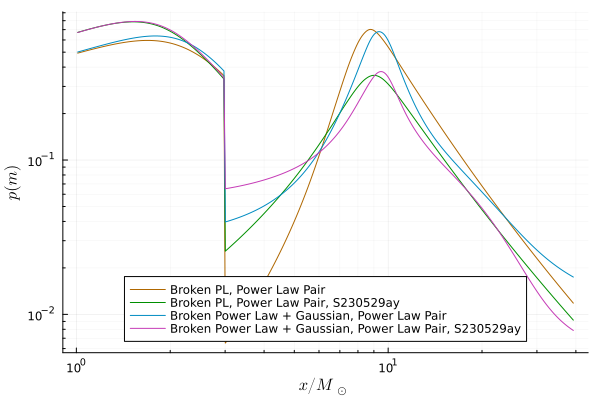

In [22]:
p = plot(xlabel=L"x/M_\odot", ylabel=L"p(m)", yscale=:log10, xscale=:log10, minorgrid=true, legend_position=:bottom)
for mf in [BrokenPowerLaw(), PowerLawGaussian()]
    k = (mf, PowerLawPairing())

    v = pm_mean_map[k]
    p = plot!(ms, ms.*v, label=label_map[k])

    v = pm_mean_extra_map[k]
    p = plot!(ms, ms.*v, label=label_map[k] * ", " * S_name)
end
p

What about $\mathrm{d} N / \mathrm{d} q \mathrm{d} V \mathrm{d} t$?

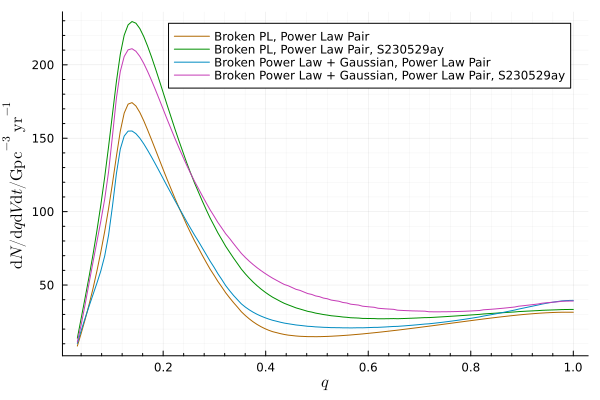

In [23]:
p = plot(xlabel=L"q", ylabel=L"\mathrm{d} N / \mathrm{d} q \mathrm{d} V \mathrm{d} t / \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}", minorgrid=true)

for mf in [BrokenPowerLaw(), PowerLawGaussian()]
    pf = PowerLawPairing()
    k = (mf,pf)

    p = plot!(qs, dNq_mean_map[k], label=label_map[k])

    p = plot!(qs, dNq_mean_extra_map[k], label=label_map[k] * ", " * S_name)
end
p

## Peak Locations

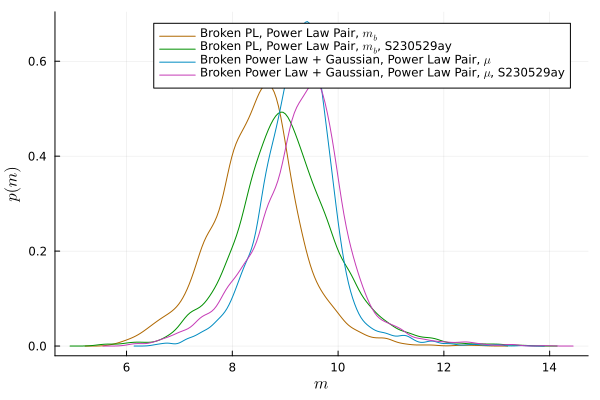

In [24]:
p = plot(xlabel=L"m", ylabel=L"p(m)")
for k in keys(traces)
    if k[1] === BrokenPowerLaw()
        p = density!(vec(traces[k].posterior.mb), label=label_map[k] * L", $m_b$")
        p = density!(vec(extra_traces[k].posterior.mb), label=label_map[k] * L", $m_b$" * ", " * S_name)
    elseif k[1] === PowerLawGaussian()
        p = density!(vec(traces[k].posterior.mu), label=label_map[k] * L", $\mu$")
        p = density!(vec(extra_traces[k].posterior.mu), label=label_map[k] * L", $\mu$" * ", " * S_name)
    end
end
p

The Gaussian + Power Law mass scale seems to be the best localized, so let's plot that alone:

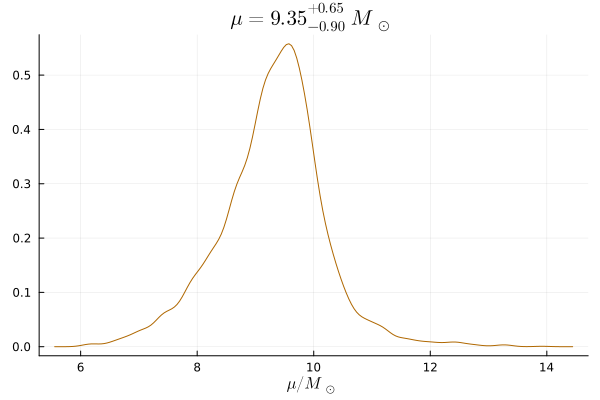

In [25]:
t = extra_traces[(PowerLawGaussian(), PowerLawPairing())]
x = vec(t.posterior.mu)
m = median(x)
l = quantile(x, 0.16)
h = quantile(x, 0.84)

density(x, xlabel=L"\mu / M_\odot", title=@sprintf("\$\\mu = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", m, h-m, m-l), label=nothing)

## Model Selection

The plot below lets us read the Bayes factor in favor of the broken power law compared to the power law plus Gaussian model from the ratio of the posterior to the prior at $f_g = 0$; it is about 1.65 in favor of the broken power law model.

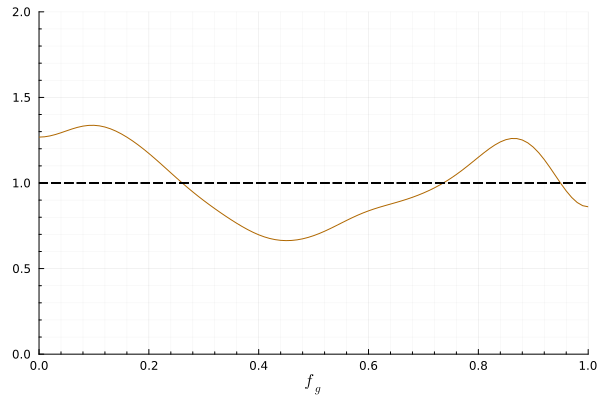

In [26]:
t = traces[PowerLawGaussian(), PowerLawPairing()]
k = BoundedKDE(vec(t.posterior.fg), lower=0, upper=1)

x = 0:0.01:1
p = plot(x, pdf.((k,), x), xlabel=L"f_g", label=nothing, minorgrid=true, xlims=(0,1), ylims=(0,2))
p = hline!(x, ones(length(x)), label=nothing, ls=:dash, color=:black)
p

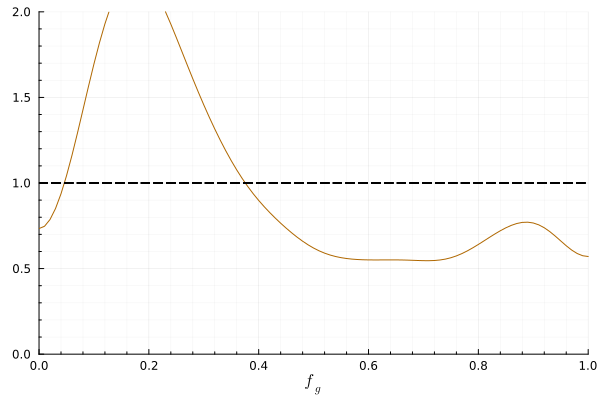

In [27]:
t = extra_traces[PowerLawGaussian(), PowerLawPairing()]
k = BoundedKDE(vec(t.posterior.fg), lower=0, upper=1)

x = 0:0.01:1
p = plot(x, pdf.((k,), x), xlabel=L"f_g", label=nothing, minorgrid=true, xlims=(0,1), ylims=(0,2))
p = hline!(x, ones(length(x)), label=nothing, ls=:dash, color=:black)
p

## $m_{1\%}$

Here again we will look with the Gaussian + Power Law model:

In [28]:
function m1pct(f, mmin=3.0)
    ms = exp.(log(mmin):0.01:log(m_upper_limit))
    fm = f.(ms)
    cfm = cumtrapz(ms, fm)

    ms[argmin(abs.(cfm/cfm[end] .- 0.01))]
end

m1pct (generic function with 2 methods)

In [29]:
m1pct_m1 = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(dNdm1_map)
)
m1pct_m2 = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(dNdm2_map)
)
m1pct_m = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(pm_map)
)

Dict{Tuple{MassFunction, PowerLawPairing}, DimArray{Float64, 2, Tuple{Dim{:draw, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}, Dim{:chain, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}}, Tuple{}, Matrix{Float64}, Symbol, DimensionalData.Dimensions.LookupArrays.NoMetadata}} with 2 entries:
  (BrokenPowerLaw(), Power… => [4.79998 6.22524 5.68944 6.67662; 5.52129 5.8627…
  (PowerLawGaussian(), Pow… => [3.21752 3.15381 3.12243 3.41649; 3.12243 3.1538…

In [30]:
m1pct_extra_m1 = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(dNdm1_extra_map)
)
m1pct_extra_m2 = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(dNdm2_extra_map)
)
m1pct_extra_m = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(pm_extra_map)
)

Dict{Tuple{MassFunction, PowerLawPairing}, DimArray{Float64, 2, Tuple{Dim{:draw, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}, Dim{:chain, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}}, Tuple{}, Matrix{Float64}, Symbol, DimensionalData.Dimensions.LookupArrays.NoMetadata}} with 2 entries:
  (BrokenPowerLaw(), Power… => [3.70103 3.66421 3.24986 3.52053; 4.61177 4.0495…
  (PowerLawGaussian(), Pow… => [3.09136 3.09136 3.09136 3.15381; 3.0606 3.12243…

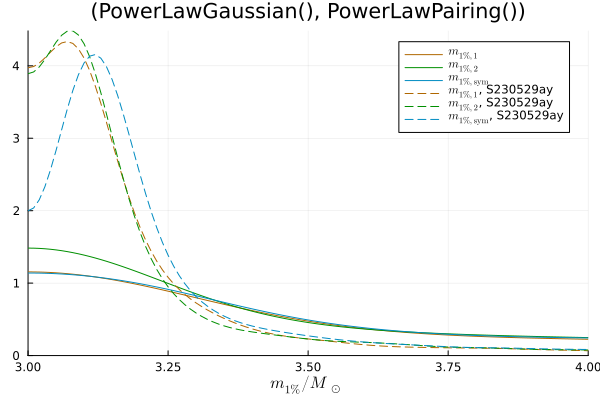

In [31]:
m1ps = 3:0.01:4
ymax = 1.6

k = (PowerLawGaussian(), PowerLawPairing())

p = plot(xlabel=L"m_{1\%} / M_\odot", xlims=(3, 4), title=string(k), ylims=(0, Inf))
for (i, (ms, lab)) in enumerate(zip([m1pct_m1[k], m1pct_m2[k], m1pct_m[k]], [L"m_{1\%,1}", L"m_{1\%,2}", L"m_{1\%,\mathrm{sym}}"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i)
end

for (i, (ms, lab)) in enumerate(zip([m1pct_extra_m1[k], m1pct_extra_m2[k], m1pct_extra_m[k]], [L"m_{1\%,1}" * ", $(S_name)", L"m_{1\%,2}" * ", $(S_name)", L"m_{1\%,\mathrm{sym}}" * ", $(S_name)"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i, linestyle=:dash)
end

p

And what about for the broken power law, where it looks more severe?

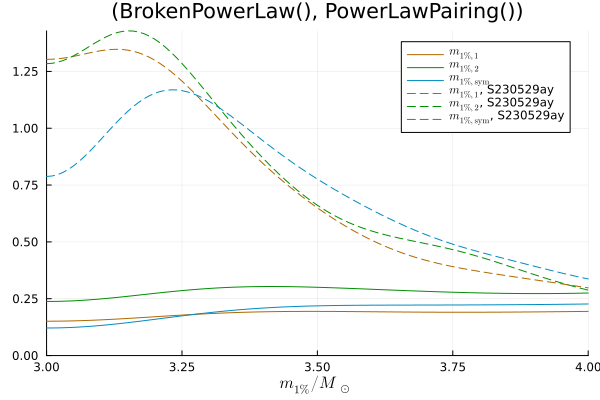

In [32]:
m1ps = 3:0.01:6
ymax = 1.6

k = (BrokenPowerLaw(), PowerLawPairing())

p = plot(xlabel=L"m_{1\%} / M_\odot", xlims=(3, 4), title=string(k), ylims=(0, Inf))
for (i, (ms, lab)) in enumerate(zip([m1pct_m1[k], m1pct_m2[k], m1pct_m[k]], [L"m_{1\%,1}", L"m_{1\%,2}", L"m_{1\%,\mathrm{sym}}"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i)
end

for (i, (ms, lab)) in enumerate(zip([m1pct_extra_m1[k], m1pct_extra_m2[k], m1pct_extra_m[k]], [L"m_{1\%,1}" * ", $(S_name)", L"m_{1\%,2}" * ", $(S_name)", L"m_{1\%,\mathrm{sym}}" * ", $(S_name)"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i, linestyle=:dash)
end

p

In [33]:
for k in [(PowerLawGaussian(), PowerLawPairing()), (BrokenPowerLaw(), PowerLawPairing())]
    m1p = m1pct_m[k]
    m = median(vec(m1p))
    ll,l,h,hh = quantile.((vec(m1p),), [0.025, 0.16, 0.84, 0.975]) # hdi_interval(vec(m1p), 0.68)
    
    @printf("%s: m_1%% = %.3f + %.3f - %.3f (1-sigma) or [%.1f - %.1f] (2-sigma)\n", string(k), m, h-m, m-l, ll, hh)
end

(PowerLawGaussian(), PowerLawPairing()): m_1% = 3.592 + 1.660 - 0.469 (1-sigma) or [3.1 - 6.4] (2-sigma)
(BrokenPowerLaw(), PowerLawPairing()): m_1% = 5.097 + 1.005 - 1.245 (1-sigma) or [3.2 - 6.7] (2-sigma)


In [34]:
@printf("With %s:\n", S_name)
for k in [(PowerLawGaussian(), PowerLawPairing()), (BrokenPowerLaw(), PowerLawPairing())]
    m1p = m1pct_extra_m[k]
    m = median(vec(m1p))
    ll,l,h,hh = quantile.((vec(m1p),), [0.025, 0.16, 0.84, 0.975]) # hdi_interval(vec(m1p), 0.68)
    
    @printf("%s: m_1%% = %.3f + %.3f - %.3f (1-sigma) or [%.1f - %.1f] (2-sigma)\n", string(k), m, h-m, m-l, ll, hh)
end

With S230529ay:
(PowerLawGaussian(), PowerLawPairing()): m_1% = 3.122 + 0.226 - 0.031 (1-sigma) or [3.1 - 4.2] (2-sigma)
(BrokenPowerLaw(), PowerLawPairing()): m_1% = 3.486 + 0.814 - 0.300 (1-sigma) or [3.1 - 5.3] (2-sigma)


What about the upper limit?

In [35]:
for k in [(PowerLawGaussian(), PowerLawPairing()), (BrokenPowerLaw(), PowerLawPairing())]
    m1p = m1pct_m[k]
    @printf("%s: m_1%% < %.1f at 2-sigma\n", string(k), quantile(vec(m1p), 0.95))
end

(PowerLawGaussian(), PowerLawPairing()): m_1% < 6.1 at 2-sigma
(BrokenPowerLaw(), PowerLawPairing()): m_1% < 6.5 at 2-sigma


In [36]:
println("With $(S_name):")
for k in [(PowerLawGaussian(), PowerLawPairing()), (BrokenPowerLaw(), PowerLawPairing())]
    m1p = m1pct_extra_m[k]
    @printf("%s: m_1%% < %.1f at 2-sigma\n", string(k), quantile(vec(m1p), 0.95))
end

With S230529ay:
(PowerLawGaussian(), PowerLawPairing()): m_1% < 3.9 at 2-sigma
(BrokenPowerLaw(), PowerLawPairing()): m_1% < 5.0 at 2-sigma
